### Progetto e Dataset

Verrà analizzato un dataset contentente informazioni (Età, Sesso, Classe Sociale, Luogo di imbarco) dei passeggeri del Titanic con lo scopo di costruire un modello di machine learning supervisionato che permetta di prevedere la sopravvivenza al naufragio di un passeggero. 
È stato scelto per lo scopo un modello 'Decision Tree Classifier', idoneo a risolvere problemi di classificazione come il suddetto.

#### Importazione dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_csv('titanic_subset_S2I.csv')

In [5]:
df.head()

,PassengerId,Sex,Age,Pclass,Embarked,Survived
0,1,male,22.0,3,S,0
1,2,female,38.0,1,C,1
2,3,female,26.0,3,S,1
3,4,female,35.0,1,S,1
4,5,male,35.0,3,S,0


In [6]:
df.shape

(891, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Sex          891 non-null    object 
 2   Age          714 non-null    float64
 3   Pclass       891 non-null    int64  
 4   Embarked     889 non-null    object 
 5   Survived     891 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 41.9+ KB


Si nota che alcune features (Age e Embarked) presentano dei campi nulli che andranno gestiti in fase di data preprocessing. Le features 'Sex', 'Embarked' e 'Pclass' rappresentano dati categorici che andranno trasformati prima di importarli nel modello di ML per l'addestramento ed il testing.

#### Data Exploration

Andiamo a valutare come le varie features del datset siano o meno correlate con il target dell'analisi, ovvero la probabilità di sopravvivenza del passeggero

In [11]:
# analizziamo una panoramica delle features numeriche del dataset
df.describe()

,PassengerId,Age,Pclass,Survived
count,891.000000,714.000000,891.000000,891.000000
mean,446.000000,29.699118,2.308642,0.383838
std,257.353842,14.526497,0.836071,0.486592
min,1.000000,0.420000,1.000000,0.000000
25%,223.500000,20.125000,2.000000,0.000000
50%,446.000000,28.000000,3.000000,0.000000
75%,668.500000,38.000000,3.000000,1.000000
max,891.000000,80.000000,3.000000,1.000000


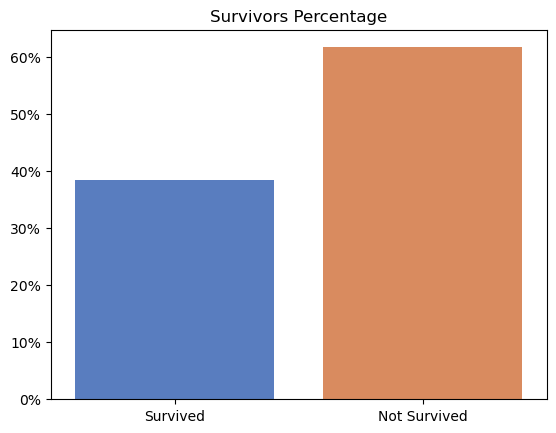

In [12]:
# valutiamo la percentuale di sopravvissuti
y = [df.Survived.mean(), 1 - df.Survived.mean()]
x = ["Survived", "Not Survived"]

sns.barplot(x=x, y=y, hue=y, palette="muted", legend=False)

plt.title("Survivors Percentage")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.show()

Tra gli 891 passeggeri analizzati il rapporto tra sopravvissuti e non sopravvissuti è circa 40-60. Le due **classi** sono dunque **leggermente sbilanciate**, fattore da tenere in considerazione nelle **metriche utili a valutare le performance del modello**.

##### Age correlation

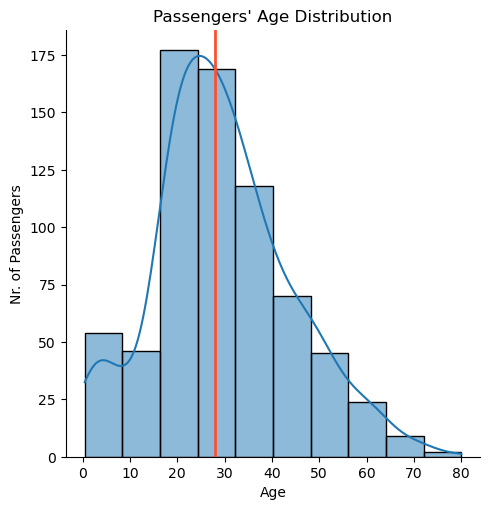

In [15]:
# distribuzione dell'età dei passeggeri imbarcati
sns.displot(df["Age"], kde=True, bins=10)

median_age = df["Age"].median()
plt.axvline(median_age, color="#fc4f30", linewidth=2)

plt.title("Passengers' Age Distribution")
plt.ylabel("Nr. of Passengers")
plt.xlabel("Age")
plt.show()

Si nota come la maggior parte dei passeggeri imbarcati abbia un'età compresa tra i 18 ed i 40 anni. I passeggeri di età superiore a 60 anni rappresentano invece degli outliers. Tale considerazione è importante in fase di data cleaning, in quanto ben 177 record della feature 'Age' presentano valori nulli. A fronte della presenza di questi outliers sarà consigliabile utilizzare la mediana (e non la media, sporcata e poco rappresentativa a causa di questi valori estremi) per riempire questi null mantenendo l'integrità della distribuzione originale

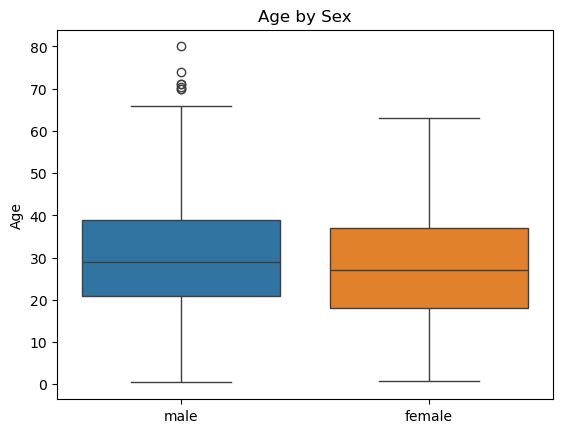

In [17]:
# distribuzione delle età divise per genere
sns.boxplot(x="Sex", y="Age", data=df, hue="Sex")
plt.title("Age by Sex")
plt.xlabel("")
plt.show()

La distribuzione delle età divise degli uomini e donne imbarcati è molto simile

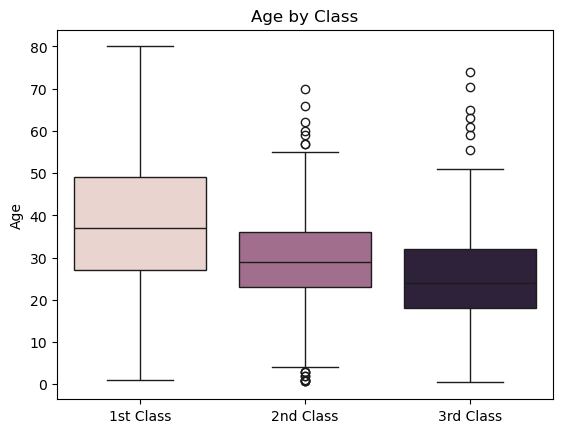

In [19]:
# distribuzione delle età divise per classe
sns.boxplot(x="Pclass", y="Age", data=df, hue="Pclass")
plt.title("Age by Class")

classi = ["1st Class", "2nd Class", "3rd Class"]
plt.xticks(range(len(classi)), classi)
plt.xlabel("")
plt.legend().set_visible(False)
plt.show()

Si nota una correlazione tra l'età dei passeggeri e la classe di appartenenza: passeggeri di classe sociale più elevata hanno mediamente un`età più alta

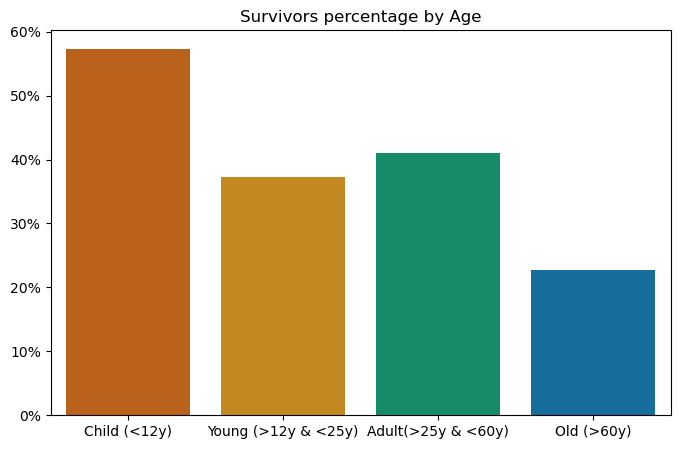

In [21]:
# correlazione tra età e probabilità di sopravvivenza
y1 = [
    df[(df.Age < 12)]["Survived"].mean(),
    df[(df.Age > 12) & (df.Age < 25)]["Survived"].mean(),
    df[(df.Age > 25) & (df.Age < 60)]["Survived"].mean(),
    df[(df.Age > 60)]["Survived"].mean(),
]
x1 = ["Child (<12y)", "Young (>12y & <25y)", "Adult(>25y & <60y)", "Old (>60y)"]

plt.figure(figsize=(8, 5))
sns.barplot(x=x1, y=y1, hue=y1, palette="colorblind", legend=False)

plt.title("Survivors percentage by Age")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.show()

C'è una correlazione inversa tra l'età e la percentuale di sopravvivenza dei passeggeri: più giovani i passeggeri, maggiore la probabilità di salvarsi. Si nota tuttavia una discontinuità in questo andamento nella categoria denominata 'Adults', che presenta una più alta probabilità di sopravvivenza rispetto al trend plausibilmente influenzata dalle altre variabili quali su tutte la classe sociale di appartenza (in cui, per come visto sopra, l' età dei passeggeri di prima classe è piu`alta - e come vedremo poi sono stati privilegiati nella possibilità di salvarsi) 

##### Class correlation

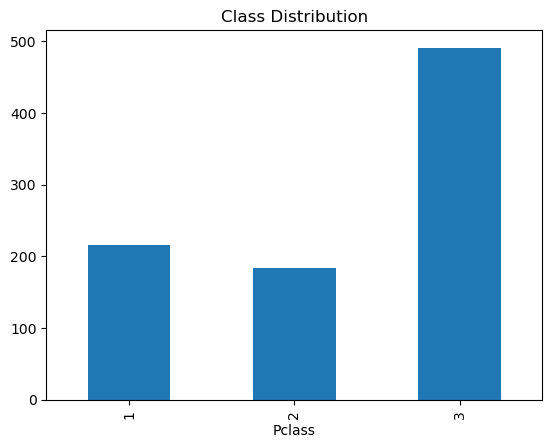

In [24]:
# Numero passeggeri imbarcati suddivisi per classe
df["Pclass"].value_counts().sort_index().plot(kind="bar", title="Class Distribution")
plt.show()

Tra i passeggeri imbarcati quelli di terza classe sono più del doppio rispetto a quelli sia di prima che di seconda classe

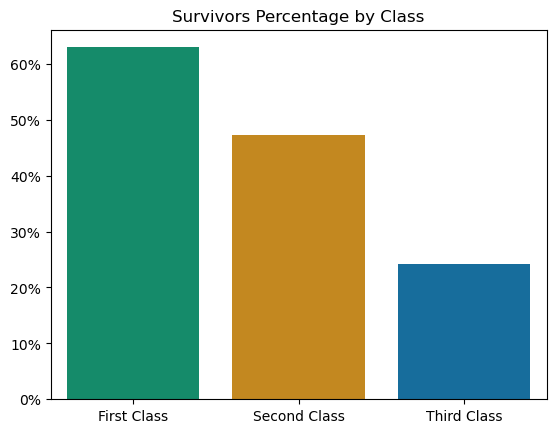

In [26]:
# percentuale di sopravvissuti suddivisi per classe
y = [
    df["Survived"][df.Pclass == 1].mean(),
    df["Survived"][df.Pclass == 2].mean(),
    df["Survived"][df.Pclass == 3].mean(),
]
x = ["First Class", "Second Class", "Third Class"]

sns.barplot(x=x, y=y, hue=y, palette="colorblind", legend=False)

plt.title("Survivors Percentage by Class")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.show()

Si nota come la classe sociale di appartenenza abbia avuto un ruolo importante sulla probabilità di sopravvivenza dei passeggeri: sono stati privilegiati i passeggeri di classe più alta

##### Sex correlation

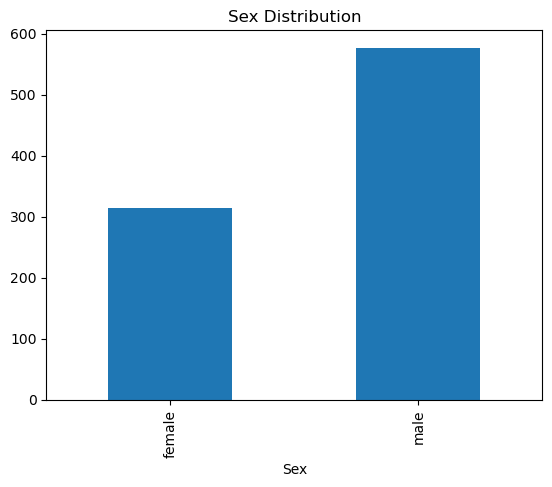

In [29]:
# Conteggio uomini e donne a bordo
df["Sex"].value_counts().sort_index().plot(kind="bar", title="Sex Distribution")
plt.show()

Gli uomini a bordo sono circa il doppio delle donne

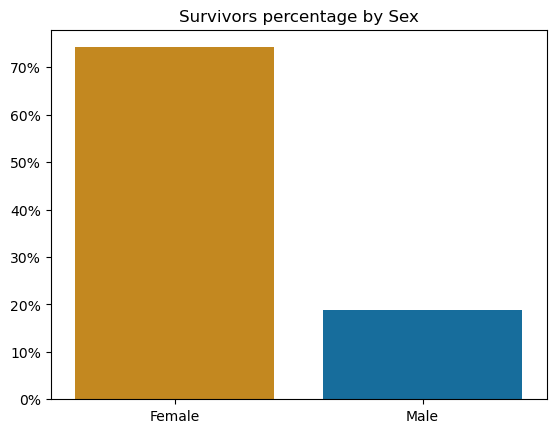

In [31]:
# Percentuale sopravvissuti per genere
y = [
    df.groupby("Sex")[["Survived"]].mean().iloc[0, 0],
    df.groupby("Sex")[["Survived"]].mean().iloc[1, 0],
]
x = ["Female", "Male"]

sns.barplot(x=x, y=y, hue=y, palette="colorblind", legend=False)

plt.title("Survivors percentage by Sex")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.show()

Si nota come siano state privilegiate le donne nella scelta tra chi salvare e chi no

##### Embarked correlation

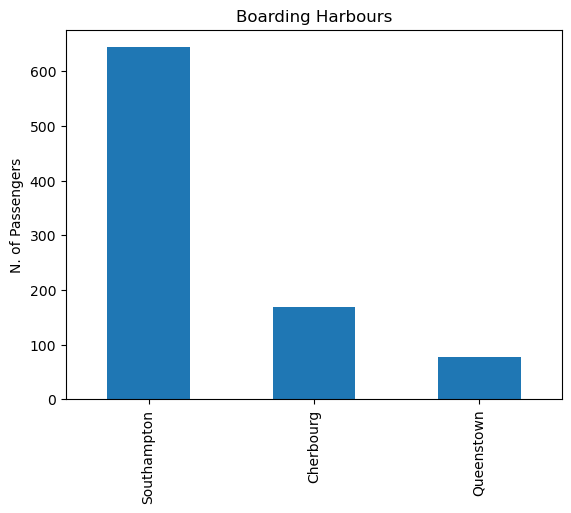

In [34]:
# valutiamo la distribuzione del luogo di imbarco dei passeggeri
df["Embarked"].value_counts().plot(kind="bar", title="Boarding Harbours")

plt.ylabel("N. of Passengers")
plt.xlabel("")
harbours = ["Southampton", "Cherbourg", "Queenstown"]
plt.xticks(range(len(harbours)), harbours)
plt.show()

La maggior parte dei passeggeri è stata imbarcata a Southampton (S). Sarà utilizzato questo dato (la moda) per rimepire i (pochi) valori nulli della feature 'Embarked'

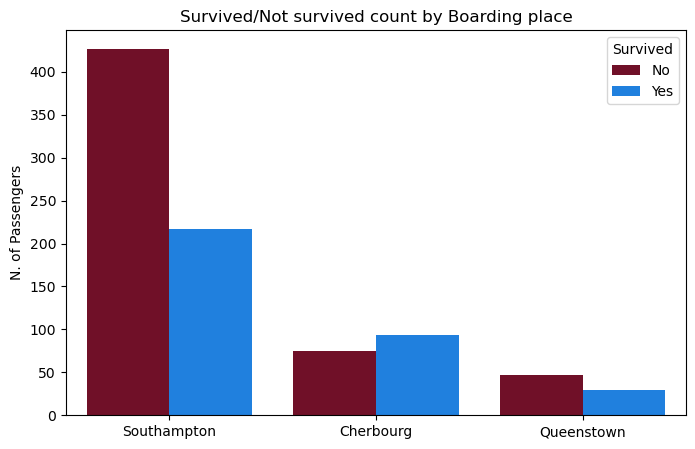

In [36]:
# valutiamo un eventuale correlazione tra il luogo di imbarco e la possibilità di sopravvivenza
plt.figure(figsize=(8, 5))
sns.countplot(x="Embarked", hue="Survived", data=df, palette=["#800020", "#0080FE"])

plt.title("Survived/Not survived count by Boarding place")
plt.xlabel("")
plt.ylabel("N. of Passengers")
plt.legend(title="Survived", labels=["No", "Yes"])

harbours = ["Southampton", "Cherbourg", "Queenstown"]
plt.xticks(range(len(harbours)), harbours)

plt.show()

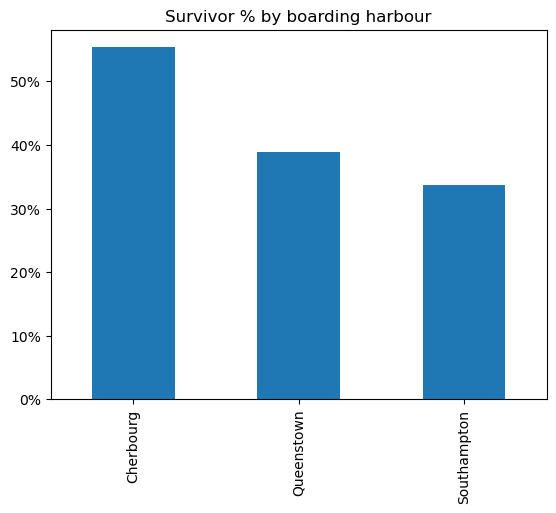

In [37]:
survival_rate_embarked = df.groupby("Embarked")["Survived"].mean().reset_index()
survival_rate_embarked.plot(kind="bar", x="Embarked", y="Survived")


plt.title("Survivor % by boarding harbour")
plt.xlabel("")
harbours = ["Cherbourg", "Queenstown", "Southampton"]
plt.xticks(range(len(harbours)), harbours)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.legend().set_visible(False)

plt.show()

La cosa che balza all'occhio è che i passeggeri saliti al porto di Cherbourg sono quelli con possibilità di sopravvivenza più alta, mentre quelli di Southampton con quella più bassa. Verifichiamone i motivi cercando una correlazione tra il luogo di imbarco e la classe di appartenenza/sesso.

In [39]:
df.groupby("Embarked")["Pclass"].value_counts()

Embarked  Pclass
C         1          85
          3          66
          2          17
Q         3          72
          2           3
          1           2
S         3         353
          2         164
          1         127
Name: count, dtype: int64

Effettivamente tra gli imbarcati a Cherbourg vi è una buona parte di passegeri di prima classe, all'opposto di Southampton ove gli imbarcati sono maggiormente di terza classe

In [41]:
df.groupby("Embarked")["Sex"].value_counts()

Embarked  Sex   
C         male       95
          female     73
Q         male       41
          female     36
S         male      441
          female    203
Name: count, dtype: int64

Si nota tuttavia una forte disparità tra gli uomini e le donne imbarcate a Southampton, anch'esso fattore che contribuisce alla bassa percentuale di sopravvissuti tra gli imbarcati in questo porto.
In sintensi in termini di probabilità di sopravvivenza si può stimare che la variabile 'luogo di imbarco' dipenda da altri fattori quali il sesso e la classe sociale.

**CONCLUSIONI**: Quali fattori contribuiscono alla possibilità di sopravvivenza dei passeggeri ed in che termini?
- il sesso: maggior possibilità di sopravvivenza per le donne
- l'età: più giovane, maggiore la possibilità di sopravvivere
- la classe sociale: più alta, maggiore la possibilità di sopravvivere
  
Sono queste le caratteristiche su cui lavorare nella fase di feature engineering per aiutare il modello nella predizione. 

### Preprocessing

#### Feature engineering

Verran create le features 'Women_1st_class' e 'Man_3d_class' che come abbiamo visto rappresentano i casi estremi di maggior possibilità di sopravvivenza e peggior possibilità di sopravvivenza per quanto riguarda la combinazione di 'Sex' e 'Pclass'. Queste due nuove colonne dovrebbero facilitare il modello nella predizione ed aumentarne le performance.

**New features: Women_1st_class and Man_3rd_class**

In [48]:
# creazione delle due nuove feature contenenti valore 1 nel caso di match delle caratteristiche e 0 nel caso di mancato match
df["Female_1st_Class"] = np.where(
    (df["Sex"] == "female") & (df["Pclass"] == 1),
    1,  # condizione è vera
    0,  # condizione è falsa
)

df["Man_3rd_class"] = np.where((df["Sex"] == "male") & (df["Pclass"] == 3), 1, 0)

df.head()

,PassengerId,Sex,Age,Pclass,Embarked,Survived,Female_1st_Class,Man_3rd_class
0,1,male,22.0,3,S,0,0,1
1,2,female,38.0,1,C,1,1,0
2,3,female,26.0,3,S,1,0,0
3,4,female,35.0,1,S,1,1,0
4,5,male,35.0,3,S,0,0,1


#### Splitting train e test set

In [50]:
# divisione df in matrice dei dati X e vettore target y
X = df.drop(columns=["PassengerId", "Survived"], axis=1)
y = df["Survived"]

In [51]:
# Splittin dei dati in training e testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25
)

In [52]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(668, 6) (223, 6) (668,) (223,)


In [53]:
# verifichiamo come si presenta la matrice dei dati e come siano stati mescolati i valori
X_train.head()

,Sex,Age,Pclass,Embarked,Female_1st_Class,Man_3rd_class
105,male,28.0,3,S,0,1
68,female,17.0,3,S,0,0
253,male,30.0,3,S,0,1
320,male,22.0,3,S,0,1
706,female,45.0,2,S,0,0


In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 105 to 684
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sex               668 non-null    object 
 1   Age               535 non-null    float64
 2   Pclass            668 non-null    int64  
 3   Embarked          666 non-null    object 
 4   Female_1st_Class  668 non-null    int32  
 5   Man_3rd_class     668 non-null    int32  
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 31.3+ KB


#### Data cleaning utilizzando ColumnTransformer

In [56]:
# importo le librerie
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [57]:
# definizione dei trasformatori
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  #encoding features categoriche
imp_mode = SimpleImputer(strategy='most_frequent')  # sostituzione valori null di Embarked: utilizzo la moda in quanto valore più significativo per la distribuzione della feature
imp_median = SimpleImputer(strategy='median') #sostituzione valori null di Age: utilizzo la mediana: meglio rappresentativa della distribuzione dei valori in quanto son presenti outliers superiori

In [58]:
# creazione della preprocessing pipeline per realizzare la pulizia delle colonne categoriche e numeriche
numeric_pipeline = Pipeline(steps=[
    ('imputer', imp_median)
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', imp_mode),  
    ('onehot', ohe)    
])

# Combinazione delle preprocessing pipeline nel ColumnTransformer
ct = ColumnTransformer(
    transformers=[
                ('numeric', numeric_pipeline, ['Age']),
                ('categorical', categorical_pipeline, ['Sex', 'Pclass', 'Embarked'])
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [59]:
ct.set_output(
    transform="pandas"
)  # output del columntransfomer come un dataframe pandas

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Age']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Pclass', 'Embarked'])])

**N.B.** : Gli encoder sono stati elaborati utilizzando solo i dati di addestramento in modo da *evitare data leakage*. Verranno successivamente applicati anche a dati di test.

### Validazione e Fitting del Modello

Lo scopo della cross-validation è valutare le performance del modello ed identificarne i migliori iperparametri (tuning del modello)

In [63]:
# importazione delle librerie
from sklearn.tree import DecisionTreeClassifier  # modello ML
from sklearn.model_selection import (
    GridSearchCV,
)  # ricerca migiliori iperparametri tramite cross validation
from sklearn.metrics import accuracy_score

In [64]:
# Creo la pipeline finale che include pre-processing (realizzato negli step precedenti) e modello
pipeline = Pipeline(
    steps=[("preprocessor", ct), ("classifier", DecisionTreeClassifier(random_state=0))]
)

In [65]:
# Definisco la griglia di iperparametri da validare del Decision Tree
param_grid = {
    "classifier__max_depth": [
        2,
        5,
        10,
        25,
        None,
    ]  #'None' significa profondità massima dell' albero (sottoinsiemi puri negli split)
}

In [66]:
# Inizializzo GridSearchCV con la pipeline e la griglia di parametri
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # cv=5 indica 5 fold per la cross-validation
    scoring="accuracy",  # ottimizza sulla base dell'accuratezza max del modello
    n_jobs=-1,  # usa tutti i core disponibili per velocizzare il processo
)

In [67]:
# Eseguo l'addestramento del modello (Esecuzione di tutta la pipeline: preprocessing + addestramento del modello ottimizzato con k-fold cross-validation)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Sex',
                                                                          'Pclass',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [2, 5, 10, 25, None]},
             scoring='accuracy')

##### È stato utilizzato *GridSearchCV* per l'ottimizzazione degli iperparametri del modello in quanto:
- Il parametro da ottimizzare era solo la max_depth dell'albero.
- I valori da testare per l'iperparametro erano pochi (5).
- Il tempo di addestramento del modello non era lungo.

*GridSearchCV* infatti esegue una ricerca esaustiva di tutte le possibili combinazioni di iperparametri definiti. Per ogni combinazione, il modello viene addestrato e validato. È l'approccio perfetto quando lo spazio di ricerca è piccolo e ben definito.

Cosa fa *GridSearchCV* così implementato:
- Per ogni combinazione di iperparametri (in questo caso, ogni valore di max_depth), divide X_train in K-fold. (K=5)
- Addestra il modello su K-1 fold e valuta le sue performance (l'accuratezza in questo caso) sul fold rimanente.
- Ripete l'operazione per ogni fold.
- Alla fine, calcola il punteggio medio di accuratezza per ogni valore di max_depth

Non è stato utilizzato *RandomizedSearchCV* in quanto, a differenza di GridSearch,  esegue una ricerca casuale su un numero fisso di combinazioni, selezionate a caso dal tuo spazio di ricerca. Questo approccio è molto più efficiente quando hai a che fare con molti iperparametri o con un range di valori molto ampio: la sua efficacia si basa sull'idea che, in molti casi, una ricerca casuale ha una probabilità molto alta di trovare una combinazione "buona" in un tempo notevolmente inferiore rispetto a una ricerca dettagliata.

In [69]:
print(
    "Miglior iperparametro trovato:", grid_search.best_params_
)  # best_params_ = miglior iperparametro della griglia trovato
print(
    "Miglior punteggio di accuratezza (cross-validation):", grid_search.best_score_
)  # best_score_ = miglior score (in questo caso l'accuratezza) trovato

Miglior iperparametro trovato: {'classifier__max_depth': 5}
Miglior punteggio di accuratezza (cross-validation): 0.8024015262035686


**N.B.** : l'oggetto grid_search ha memorizzato la migliore combinazione di iperparametri (in questo caso max_depth dell'albero) ed il modello addestrato con questi parametri (**best_estimator**).
Posso dunque utilizzarlo direttamente per valutare l`accuratezza tramite il test set.

In [71]:
# Uso il best_estimator (già fittato e ottimizzato) per la predizione utilizzando test set
y_pred = grid_search.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0], dtype=int64)

**N.B.** : *grid_search.predict* non solo realizza la predizione del modello tramite il test set, ma applica tutta la pipeline vista sopra anche a X_test:
1. *Trasformazione*: Prende X_test e lo passa al primo step della pipeline, il preprocessor. Questo preprocessor applica le trasformazioni che ha imparato da X_train (ad esempio, imputa i valori mancanti usando la media calcolata su X_train e applica l'encoder con le categorie viste in X_train).. Non avviene data leakage in quanto il fitting del modello viene fatto solo con i dati di training.
2. *Predizione*: Una volta che i dati di X_test sono stati trasformati, passano al secondo step della pipeline, il DecisionTreeClassifier. Questo modello, che è già stato ottimizzato e addestrato con i migliori iperparametri (best_estimator), fa le predizioni sui dati trasformati.

### Testing e Valutazione del modello

#### Accuracy

In [75]:
final_accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza finale di predizione del modello sul test set:", final_accuracy)

Accuratezza finale di predizione del modello sul test set: 0.8026905829596412


Posso anche valutarla direttamente tramite il metodo .score() di GridSearchCV (senza passare per y_pred)

In [77]:
final_score = grid_search.score(X_test, y_test)
print("Accuratezza finale di predizione del modello sul test set:", final_score)

Accuratezza finale di predizione del modello sul test set: 0.8026905829596412


Avevamo visto in fase di Data Exploration che le **classi** (passeggeri sopravvissuti e non sopravvissuti) del vettore delle etichette erano 
**leggermente sbilanciate** verso i secondi (40-60). Servono dunque **ulteriori metriche** oltre all'accuratezza (quante volte il modello ha indovinato in generale) per valutare le reali performance del modello supervisionato.

#### Confusion Matrix

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[124  15]
 [ 29  55]]


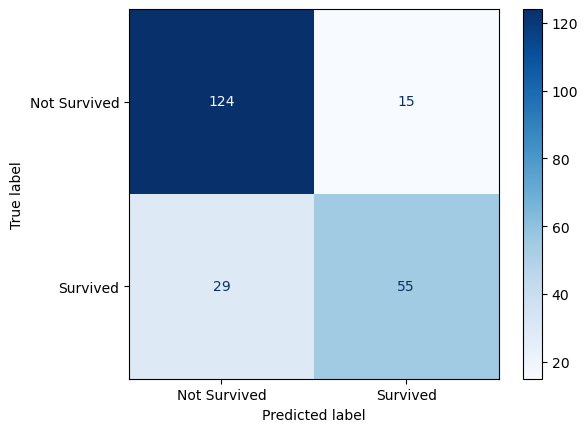

In [81]:
# plotto della confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Survived", "Survived"]
)  # specifico le etichette manualmente basandomi su y_test
# In questo caso, le etichette sono 0 e 1 (per Survived)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Il modello ha valutato correttamente 124 TN (Not survived) e 55 TP (Survived).
Ha poi predetto 29 FN (non sopravvissuti che in realtà erano sopravvissuti) e 15 FP (sopravvissuti che in realtà non lo erano). Qual'è tra questi l'errore più critico? La risposta alla domanda porta a modificare i parametri del modello in modo tale da ridurre il numero dei FN o dei FP (ed avere di conseguenza rispettivamente una più alta la Racall(Sensitivity) o più alta Precision del modello)

Tramite i valori dei TP, TN, FP, FN possiamo calcolare metriche più approfondite per valutare la performance predittiva del modello, quali la Precision e la Recall.
_____________________________________
*Classe 'Not Survived'*
_____________________________________
- Precision = TN/(TN+FN) = 124/153 = 0,81
- Recall = TN/(TN+FP) = 124/139 = 0,89

_____________________________________
*Classe 'Survived'*
_____________________________________
- Precision = TP/(TP+FP) = 55/58= 0,79
- Recall = TP/(TP+FN) = 55/84 = 0,65

#### Classification Report

Possiamo utilizzare il Classification Report per ottenerle in automatico

In [86]:
from sklearn.metrics import classification_report

print(
    classification_report(y_test, y_pred, target_names=["Not Survived", "Survived"])
)  # modifico le etichette presenti in y da [0,1] a nomi parlanti

              precision    recall  f1-score   support

Not Survived       0.81      0.89      0.85       139
    Survived       0.79      0.65      0.71        84

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



*Precision*: Risponde alla domanda: "Tra tutte le predizioni positive fatte dal modello, quante erano realmente corrette?". Un'alta precisione indica che il modello ha pochi falsi positivi.

*Recall*: Risponde alla domanda: "Tra tutte le istanze positive che dovevano essere trovate, quante il modello è riuscito a trovarne?". Un alto richiamo indica che il modello ha pochi falsi negativi.

*F1-Score*: È la media armonica di precision e recall, offrendo un equilibrio tra le due metriche. È particolarmente utile quando le classi non sono bilanciate.

*Support*: È il numero di istanze reali per ogni classe nel test set.

### Conclusioni

Il modello presenta sia un'*accuracy* che *medie (macro/weighted avg)* delle altre metriche piuttosto elevate (**80%**), quindi *in generale sembra effettuare una buona previsione*.

Tuttavia il modello riesce a *predirre in maniera più ottimale i passeggeri 'Not Survived' rispetto ai 'Survived'*. Tale concetto si può verificare osservando l'F1 score, più alto per la prima classe (85%) rispetto alla seconda(71%), e l'elevato numero di falsi negativi nella Confusion Matrix (29 FN su un totale di 84 istanze).

Come individuato in fase di Data Exploration il dataset era infatti sbilanciato (la classe 'Survived' presenta meno dati rispetto alla classe 'Non Survived'), il che spiega la maggior difficoltà del modello ad effettuare previsioni per la classe minoritaria e come la sola accuracy possa essere ingannevole per valutare il modello.

Spunti di miglioramento:
 - *Bilanciamento del Dataset* per evitare la tendenza a predirre la classe più frequente. Consigliabile oversampling della classe 'Survived' (con 'undersampling' della classe 'Not Survived' si rischia di perdere informazioni e pattern rilevanti per le performance del modello.
 - *Tuning anche degli altri iperparametri* dell'albero decisionale (non solo max_depth)
 - *Utilizzo di un altro modello* supervisionato di machine learning che potrebbe offrire performance superiori per tale problema di classificazione (es. una Random Forest)